In [169]:
#Python libraries
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import ta
import talib
import joblib
import sys
import os
from sys import argv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error



In [170]:
#check tensorflow version
print(tf.__version__)

2.12.0


In [171]:
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

False


In [172]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [173]:
#show terminal info
terminal_info=mt5.terminal_info()
print(terminal_info)

TerminalInfo(community_account=True, community_connection=True, connected=True, dlls_allowed=False, trade_allowed=True, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=4468, maxbars=100000, codepage=0, ping_last=57965, community_balance=0.0, retransmission=0.6445323078589612, company='Exness Technologies Ltd', name='MetaTrader 5 EXNESS', language='English', path='C:\\Program Files\\MetaTrader 5 EXNESS', data_path='C:\\Users\\Msyne\\AppData\\Roaming\\MetaQuotes\\Terminal\\53785E099C927DB68A545C249CDBCE06', commondata_path='C:\\Users\\Msyne\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')


In [174]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"
print(file_path)

C:\Users\Msyne\AppData\Roaming\MetaQuotes\Terminal\53785E099C927DB68A545C249CDBCE06\MQL5\Files\


In [175]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]
print("data path to save onnx model",data_path)

data path to save onnx model C:\Users\Msyne\AppData\Roaming\Python\Python310\site-packages\


In [176]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2024-05-05 13:54:45.335630
data end date= 2024-09-02 13:54:45.335630


In [177]:
#get xauusd rates (H1) from start_date to end_date
xauusd_rates = mt5.copy_rates_range("XAUUSDm", mt5.TIMEFRAME_H1, start_date, end_date)

In [178]:
#check
print(xauusd_rates)

[(1714946400, 2302.321, 2303.288, 2300.783, 2301.786, 2381, 199, 0)
 (1714950000, 2301.768, 2302.934, 2293.265, 2293.968, 4847, 199, 0)
 (1714953600, 2293.929, 2298.03 , 2291.774, 2295.971, 5531, 199, 0) ...
 (1725249600, 2496.208, 2499.532, 2496.133, 2496.858, 3905, 159, 0)
 (1725253200, 2496.899, 2498.508, 2495.191, 2496.457, 5117, 159, 0)
 (1725256800, 2496.451, 2501.457, 2495.859, 2497.834, 6366, 159, 0)]


In [179]:
#create dataframe
df = pd.DataFrame(xauusd_rates)


In [180]:
# Display the first few rows and column names
print(df.head())
print(df.columns)

         time      open      high       low     close  tick_volume  spread  \
0  1714946400  2302.321  2303.288  2300.783  2301.786         2381     199   
1  1714950000  2301.768  2302.934  2293.265  2293.968         4847     199   
2  1714953600  2293.929  2298.030  2291.774  2295.971         5531     199   
3  1714957200  2296.026  2309.145  2295.739  2308.277        13089     199   
4  1714960800  2308.328  2315.394  2307.497  2311.169         7492     199   

   real_volume  
0            0  
1            0  
2            0  
3            0  
4            0  
Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread',
       'real_volume'],
      dtype='object')


In [181]:
# Ensure data is sorted by the correct date column
df.sort_values('time', inplace=True)

# Calculate RSI using the '<CLOSE>' price column
df['RSI'] = talib.RSI(df['close'], timeperiod=14)

# Display the first few rows to verify
print(df.head())

         time      open      high       low     close  tick_volume  spread  \
0  1714946400  2302.321  2303.288  2300.783  2301.786         2381     199   
1  1714950000  2301.768  2302.934  2293.265  2293.968         4847     199   
2  1714953600  2293.929  2298.030  2291.774  2295.971         5531     199   
3  1714957200  2296.026  2309.145  2295.739  2308.277        13089     199   
4  1714960800  2308.328  2315.394  2307.497  2311.169         7492     199   

   real_volume  RSI  
0            0  NaN  
1            0  NaN  
2            0  NaN  
3            0  NaN  
4            0  NaN  


In [182]:
# Verify the column names
print(df.columns)

# Convert the column to the correct data type if necessary
df['close'] = df['close'].astype(float)

# Calculate the RSI
df['RSI'] = talib.RSI(df['close'], timeperiod=14)

# Display the RSI values
print(df[['close', 'RSI']].tail(20))

Index(['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread',
       'real_volume', 'RSI'],
      dtype='object')
         close        RSI
1935  2515.320  46.236786
1936  2519.523  52.167323
1937  2519.591  52.259079
1938  2515.457  46.428162
1939  2509.161  39.246081
1940  2502.501  33.366185
1941  2497.728  29.907898
1942  2499.508  32.708974
1943  2502.343  37.025537
1944  2502.343  37.025537
1945  2503.342  38.634287
1946  2503.468  38.846482
1947  2502.980  38.294180
1948  2501.574  36.676251
1949  2498.011  32.884551
1950  2491.966  27.659825
1951  2496.228  35.447159
1952  2496.858  36.534729
1953  2496.457  36.117620
1954  2497.834  38.705473


In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

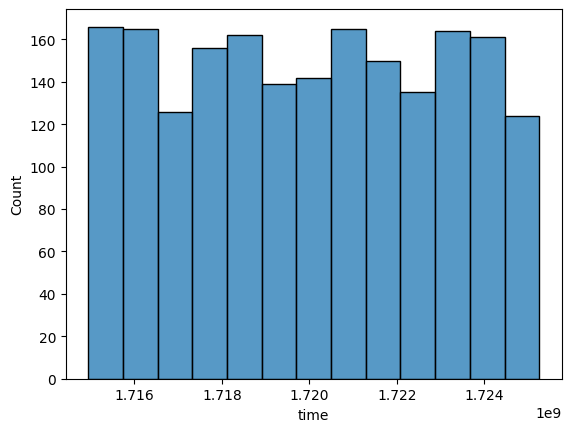

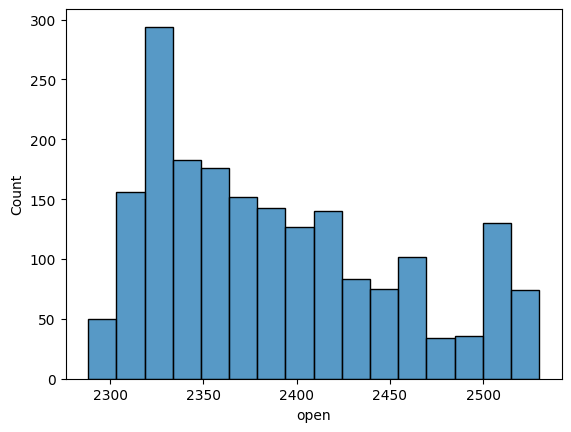

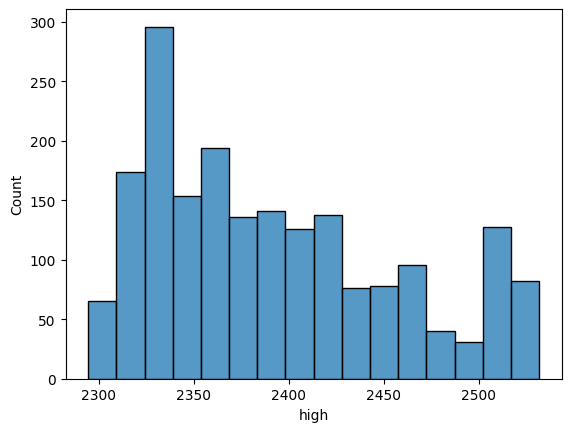

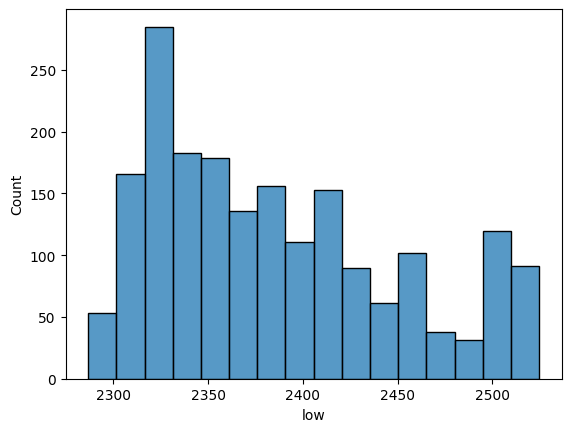

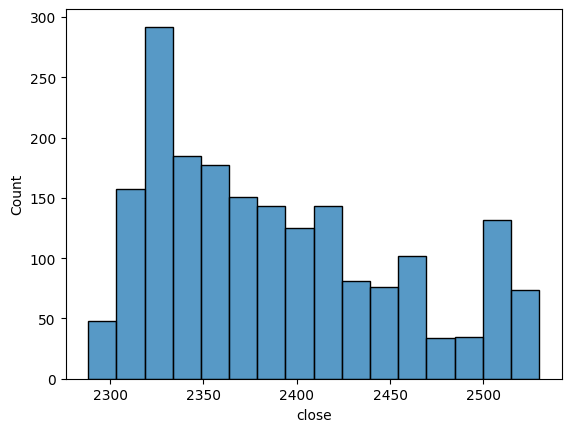

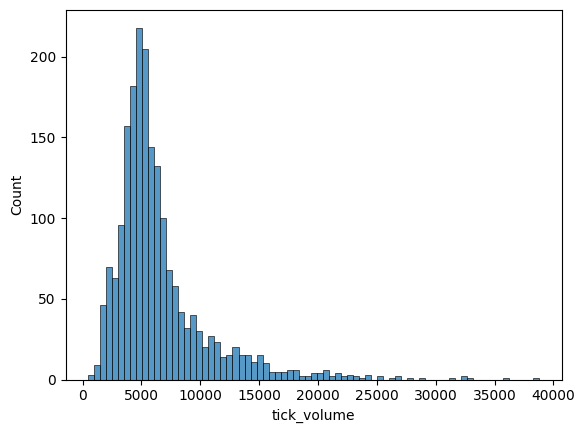

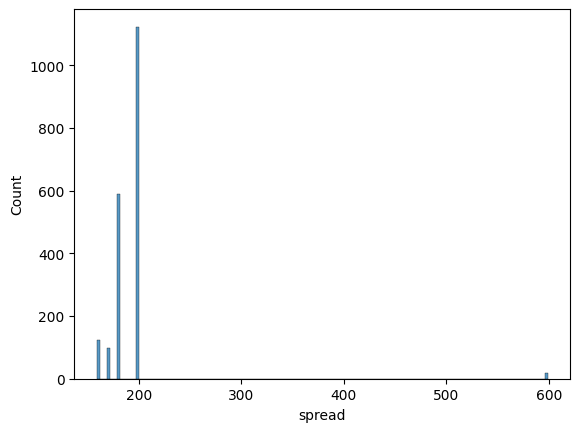

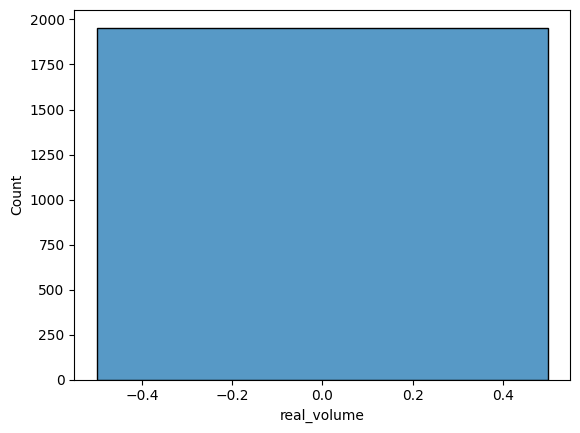

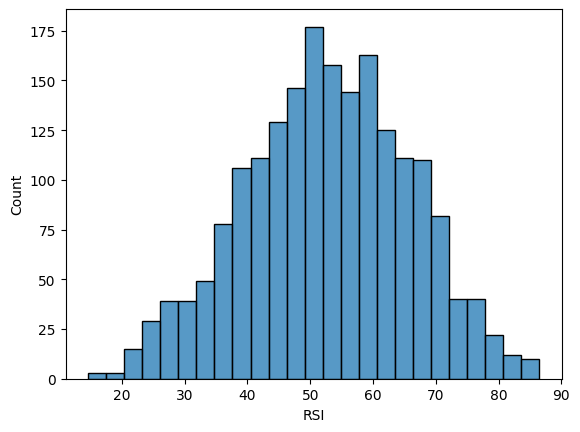

In [184]:
warnings.filterwarnings("ignore")

for i in df.select_dtypes(include="number").columns:
    sns.histplot(data=df, x=i)
    plt.show()

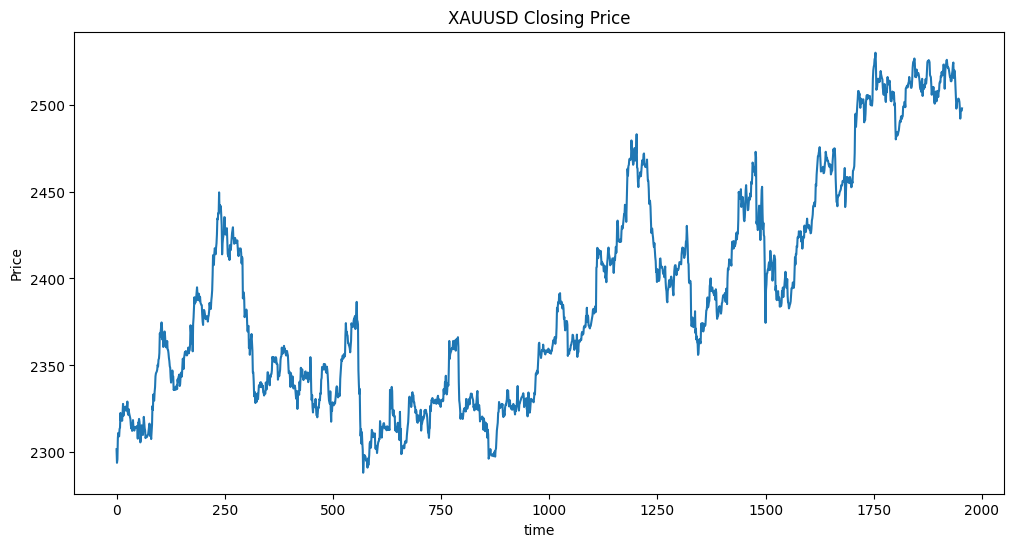

In [185]:
# Visualize the closing price
plt.figure(figsize=(12, 6))
plt.plot(df['close'])
plt.title('XAUUSD Closing Price')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [186]:
# Feature Engineering
df['RSI'] = talib.RSI(df['close'], timeperiod=14)

In [187]:
# Drop rows with missing values
df.dropna(inplace=True)

In [188]:
# Define target variable
df['Target'] = df['close'].shift(-1)
df.dropna(inplace=True)

In [189]:
# Split the data
X = df[['RSI']]  # Only use RSI as the feature
y = df['Target']

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [191]:
# Model Development
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [192]:
# Predictions
y_pred = model.predict(X_test)

In [193]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 16190.329919713775


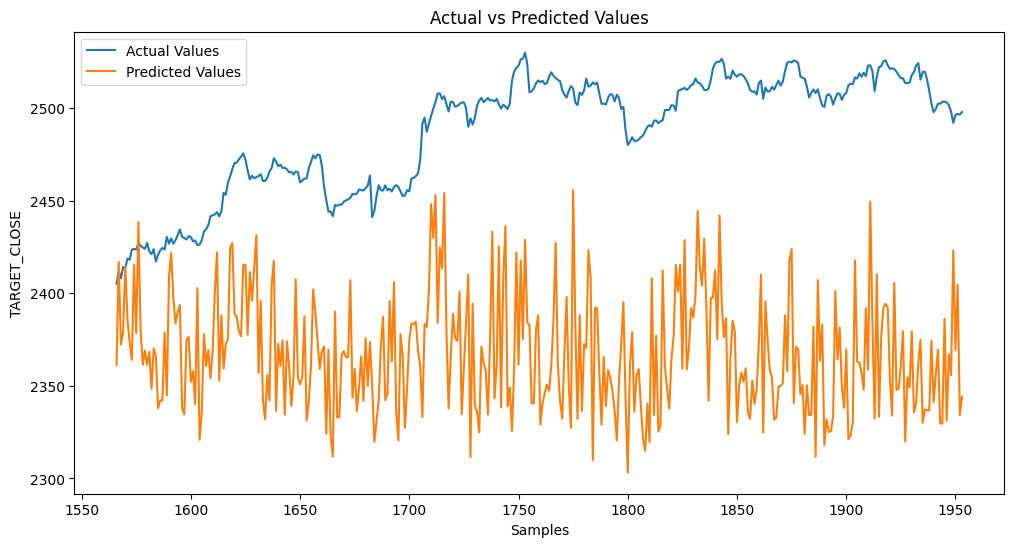

In [194]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Values')
plt.plot(y_test.index, y_pred, label='Predicted Values')
plt.xlabel('Samples')
plt.ylabel('TARGET_CLOSE')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()